# Library

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import StandardScaler

# Function: get_data()

In [31]:
scaler = StandardScaler()
def get_data():
    df1 = pd.read_csv('EPL_22_23.csv')
    df2 = pd.read_csv('EPL_21_22.csv')
    df3 = pd.read_csv('EPL_20_21.csv')
    df4 = pd.read_csv('EPL_19_20.csv')

    df = pd.concat([df1, df2, df3, df4], axis = 0)
    df = df.sample(frac=1)
    labels = df.loc[:,['FTR']]
    labels = labels.to_numpy().reshape(-1)
    df = df.loc[:, ['Referee','MaxCH','MaxCD','MaxCA','AvgCH','AvgCD','AvgCA','MaxC>2.5','AvgC>2.5','MaxCAHH','AvgCAHH','MaxCAHA','AvgCAHA']]
    Referee_ohe_df = pd.get_dummies(df.iloc[:, 0], dtype=float)
    df = df.drop(columns = ['Referee'])
    df = pd.concat([df, Referee_ohe_df], axis=1)
    train_df = scaler.fit_transform(np.array(df))
    
    X_train, X_test, y_train, y_test = train_test_split(train_df, labels, test_size=0.2, random_state=4211)

    return X_train, X_test, y_train, y_test

# K-Nearest Neighbour Classifier

[[ 35.668   2.739  62.646]
 [ 20.473   1.497  48.205]
 [ 24.943   2.72  105.109]]
0.4680065789473684


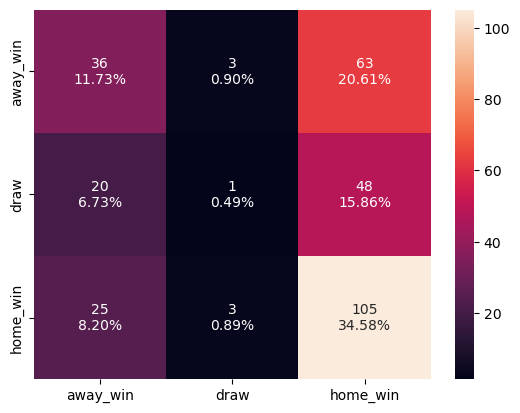

In [32]:

acc = []
cf_matrix = []
it_acc = []
all_prob = []
all_odds = []
all_index = []
all_r = [] # return for each epoch
epoch = 1000

for i in range(1, epoch + 1):
    #X_train = (1216, 43)
    #X_test (304, 43)
    X_train, X_test, y_train, y_test = get_data()
    knn = KNeighborsClassifier(n_neighbors=38)

    y_pred = knn.fit(X_train, y_train).predict(X_test)
    
    #simulation
    prob = knn.predict_proba(X_test) #shape = (304,3)
    #w = np.array(np.random.random((3,))) 
    #w = w/np.sum(w) 
    #w = np.exp(w)/np.sum(np.exp(w)) #softmax
    odds = scaler.inverse_transform(X_test)
    odds = odds[:,5:2:-1] #shape = (304,3) AvgCA---AvgCD---AvgCH
    label = y_test
    index = label.reshape(-1,1) == ['A','D','H'] #shape = (304,3)
    r = np.multiply(np.multiply(prob,odds),index)
    r = np.sum(r,axis=1)
    r = r.sum()
    #x = np.dot(odds, index.T)
    #dot_product = np.diagonal(x)
    #dot_product = dot_product.reshape(-1) #shape = (304,)
    #r = np.dot(np.dot(w,prob.T),dot_product) 
    
    #record
    all_r.append(r)
    all_odds.append(odds)
    all_prob.append(prob)
    all_index.append(index)
    cf_matrix.append(confusion_matrix(y_test, y_pred))
    acc.append(accuracy_score(y_test, y_pred))
    it_acc.append(np.sum(acc, axis=0)/i)

categories = ['away_win', 'draw', 'home_win']
cf_matrix = np.sum(cf_matrix, axis= 0)/epoch
mean_acc = np.sum(acc, axis=0)/epoch
#f1 = np.sum(f1, axis=0)/5

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)
sns.heatmap(cf_matrix, annot=labels, xticklabels = ['away_win', 'draw', 'home_win'], yticklabels = ['away_win', 'draw', 'home_win'], fmt='')
print(cf_matrix)
print(mean_acc)

# Plot

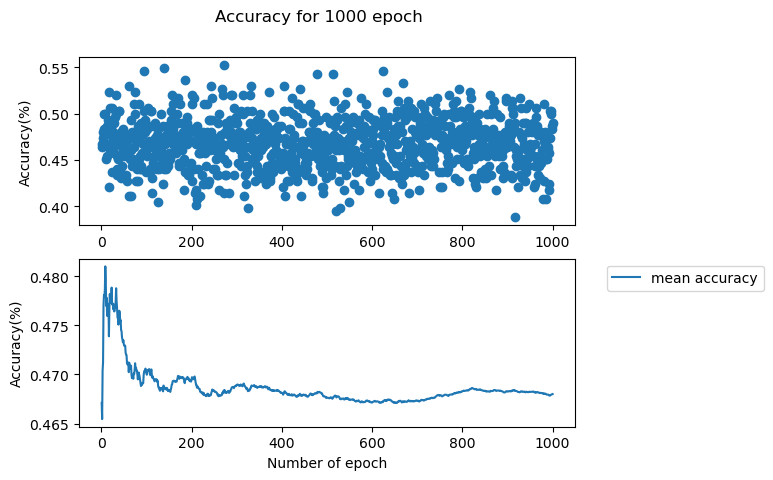

In [40]:
import matplotlib.pyplot as plt
e=list(range(1,epoch + 1))
fig1, (ax1, ax2) = plt.subplots(2,1)
fig1.suptitle('Accuracy for 1000 epoch') 

ax1.scatter(e, acc, label='accuracy')
ax1.set_ylabel('Accuracy(%)')

ax2.plot(e,it_acc,label='mean accuracy')
ax2.set_xlabel('Number of epoch')
ax2.set_ylabel('Accuracy(%)')

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [43]:
print('minimum accuracy: ',np.min(acc))
print('maximum accuracy: ',np.max(acc))
print('mean accuracy: ', mean_acc)

minimum accuracy:  0.3881578947368421
maximum accuracy:  0.5526315789473685
mean accuracy:  0.4680065789473684


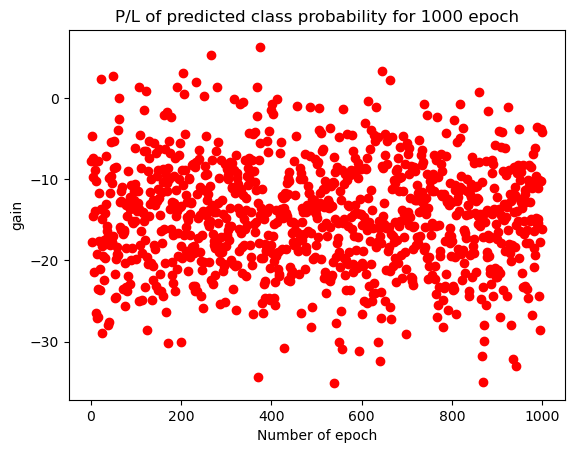

In [44]:
gain = np.array(all_r) - 304
plt.scatter(e,gain,label='r',color='red')
plt.xlabel('Number of epoch')
plt.ylabel('gain')
plt.title('P/L of predicted class probability for 1000 epoch')
plt.show()

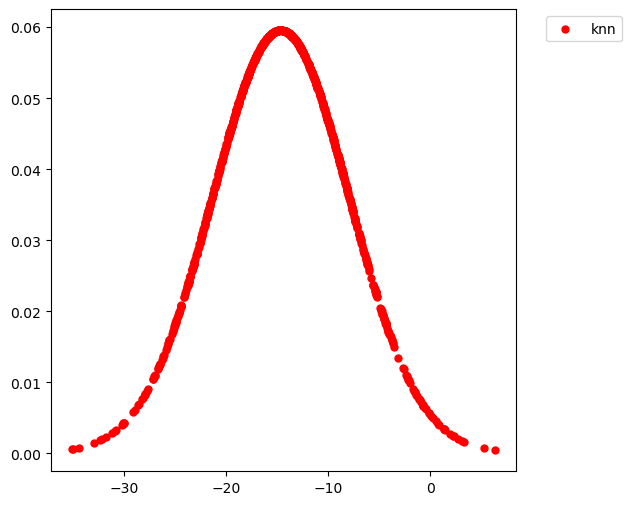

In [55]:
# A custom function to calculate 
# probability distribution function 
def pdf(x): 
    mean = np.mean(x) 
    std = np.std(x, ddof=1) 
    y_out = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2)) 
    return y_out 
    
# To generate an array of x-values 
x = gain
  
# To generate an array of 
# y-values using corresponding x-values 
y = pdf(x) 
  
# Plotting the bell-shaped curve 

plt.figure(figsize = (6, 6)) 
#plt.plot(x, y, color = 'black', linestyle = 'dashed') 
  
plt.scatter( x, y, marker = 'o', s = 25, color = 'red', label='knn') 
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [46]:
from scipy.stats import skew, kurtosis  

print(np.mean(gain))
print(np.median(gain))
print(np.std(gain, ddof=1))
print(skew(gain, bias=True))
print(kurtosis(gain, bias=True))

-14.664149736842111
-14.531578947368445
6.696229207182721
0.018525660044581515
0.005727139989138763


In [36]:
i = np.array(all_r).argmax()
best_w = all_prob[i]
rng_w = np.array(np.random.random((3,))) 
rng_w = np.exp(rng_w)/np.sum(np.exp(rng_w))

In [47]:
all_pnl = []
rng_pnl =[]
home_pnl = []
for i in range(epoch):

    # strat from model
    odds = all_odds[i]
    index = all_index[i]
    x = np.multiply(odds,index)
    #r = np.dot(np.dot(best_w,prob.T),odds)-304
    r = np.multiply(best_w,x)
    all_pnl.append(r.sum()-304)

    #random bet
    rng = np.multiply(rng_w,x)
    rng_pnl.append(rng.sum()-304)

    #all in home team 
    home = np.multiply(np.array([0,0,1]),x)
    home_pnl.append(home.sum()-304)

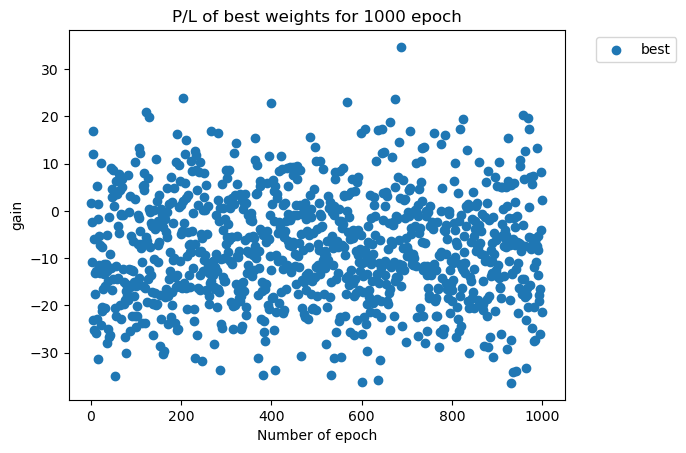

In [48]:
plt.scatter(e,all_pnl,label='best')

plt.xlabel('Number of epoch')
plt.ylabel('gain')
plt.title('P/L of best weights for 1000 epoch')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

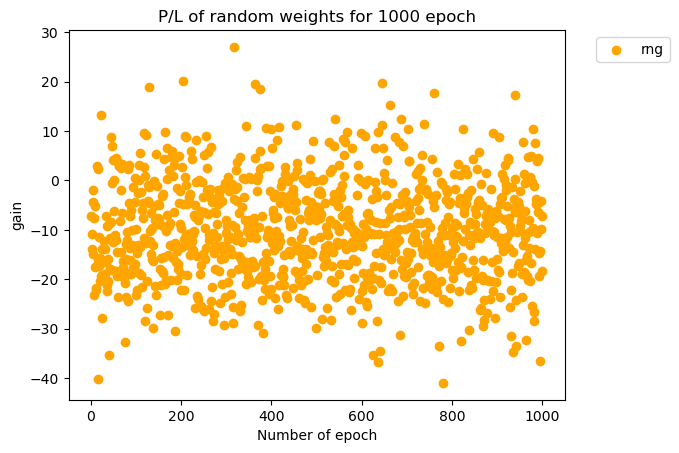

In [49]:
plt.scatter(e,rng_pnl,label='rng',color='orange')

plt.xlabel('Number of epoch')
plt.ylabel('gain')
plt.title('P/L of random weights for 1000 epoch')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

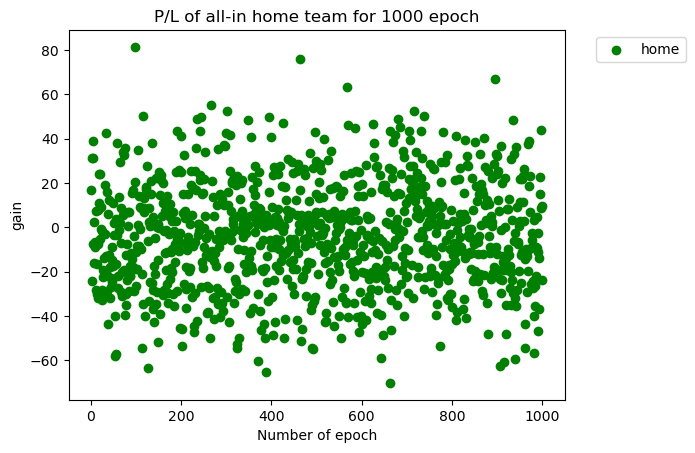

In [50]:
plt.scatter(e,home_pnl,label='home', color='green')

plt.xlabel('Number of epoch')
plt.ylabel('gain')
plt.title('P/L of all-in home team for 1000 epoch')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

-8.033452631578955
-8.502631578947387
11.412676577291895
0.17850070717521158
-0.19309733922166528
-10.181879122445789
-10.632838812909796
9.957068356106259
0.15533038676142413
0.07957354147918672
-3.986340000000003
-4.365000000000009
23.744755168339804
0.12439520945556046
-0.11566699184066698


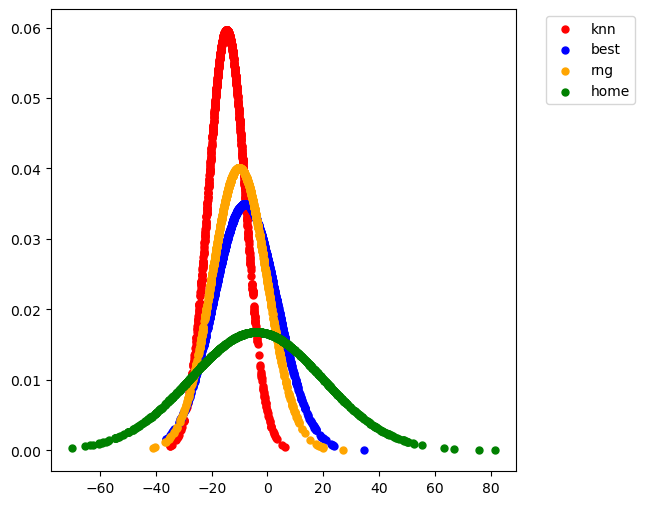

In [52]:
def pdf(x): 
    mean = np.mean(x) 
    std = np.std(x) 
    y_out = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2)) 
    return y_out 
      
#strat
a = pdf(all_pnl) 
print(np.mean(all_pnl))
print(np.median(all_pnl))
print(np.std(all_pnl))
print(skew(all_pnl, bias=True))
print(kurtosis(all_pnl, bias=True))


#random
b = pdf(rng_pnl)
print(np.mean(rng_pnl))
print(np.median(rng_pnl))
print(np.std(rng_pnl))
print(skew(rng_pnl, bias=True))
print(kurtosis(rng_pnl, bias=True))


#home blind
c = pdf(home_pnl)
print(np.mean(home_pnl))
print(np.median(home_pnl))
print(np.std(home_pnl))
print(skew(home_pnl, bias=True))
print(kurtosis(home_pnl, bias=True))

# Plotting the bell-shaped curve 

plt.figure(figsize = (6, 6)) 
#plt.plot(x, y, color = 'black', linestyle = 'dashed') 

plt.scatter( gain, pdf(gain), marker = 'o', s = 25, color = 'red', label='knn')   
plt.scatter( all_pnl, a, marker = 'o', s = 25, color = 'blue', label='best') 
plt.scatter( rng_pnl, b, marker = 'o', s = 25, color = 'orange', label='rng') 
plt.scatter( home_pnl, c, marker = 'o', s = 25, color = 'green', label='home') 
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()